<a href="https://colab.research.google.com/github/shumshersubashgautam/Computer-Aided-Drug-Discovery-Learning/blob/main/8-Protein_data_acquisition_Protein_Data_Bank_(PDB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/volkamerlab/teachopencadd.git

Cloning into 'teachopencadd'...
remote: Enumerating objects: 17115, done.
remote: Counting objects: 100% (2093/2093), done.
remote: Compressing objects: 100% (969/969), done.
remote: Total 17115 (delta 1309), reused 1786 (delta 1122), pack-reused 15022
Receiving objects: 100% (17115/17115), 849.77 MiB | 33.64 MiB/s, done.
Resolving deltas: 100% (11506/11506), done.
Updating files: 100% (468/468), done.


In [2]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 60.5 MB/s eta 0:00:00


In [3]:
cd teachopencadd

/content/teachopencadd


In [5]:
# !python setup.py install

# **Theory**
# **Protein Data Bank (PDB)**
The RCSB Protein Data Bank (PDB) is a comprehensive structural biology information database and a key resource in areas of structural biology, such as structural genomics and drug design (PDB website).

Structural data is generated from structural determination methods such as X-ray crystallography (most common method), nuclear magnetic resonance (NMR), and cryo electron microscopy (cryo-EM). For each entry, the database contains (i) the 3D coordinates of the atoms and the bonds connecting these atoms for proteins, ligand, cofactors, water molecules, and ions, as well as (ii) meta information on the structural data such as the PDB ID, the authors, the deposition date, the structural determination method used, and the structural resolution. The structural resolution is a measure of the collected data quality and has the unit Å (Angstrom); the lower the value, the higher the quality of the structure.

The PDB website offers a 3D visualization of the protein structures (with ligand interactions if available) and a structure quality metrics, as can be seen for the PDB entry of an example epidermal growth factor receptor (EGFR) with the PDB ID 3UG5.
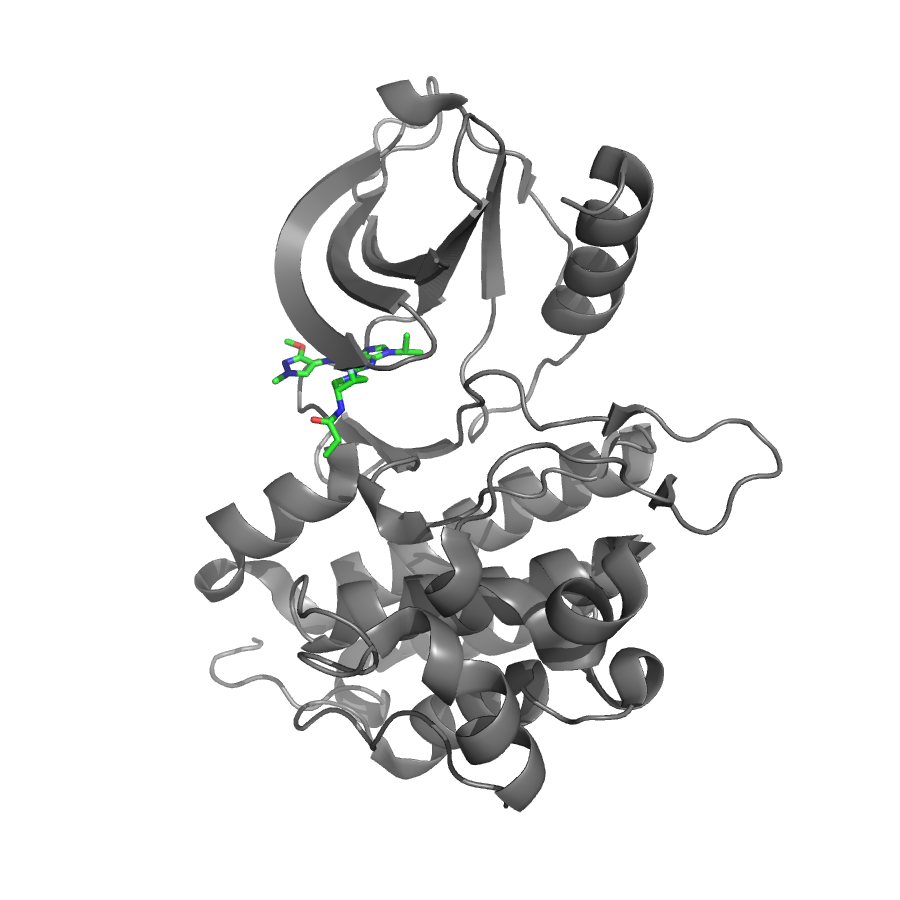

Figure 1: The protein structure (in gray) with an interacting ligand (in green) is shown for an example epidermal growth factor receptor (EGFR) with the PDB ID 3UG5.

Query the PDB using the Python packages biotite and pypdb
Each structure in the PDB database is linked to many different fields to hold meta information. Check out the complete list of available fields for chemicals/structures and supported operators on the RCSB website. The Python package biotite provides the convenient module databases.rcsb (see docs), which allows us to query one (FieldQuery, see docs) or more (CompositeQuery, see docs) of these fields to retrieve a count (count) or list (search) of PDB IDs that match our criteria.

The Python package pypdb offers an interface for the PDB to not only query for PDB IDs but also to download associated metadata and structural files (Bioinformatics (2016), 1, 159-60, documentation). Check out the demo notebook introducing the pypdb API.

We will use both packages in this notebook: biotite to quickly filter down the many structures in the PDB given certain criteria and pypdb to download metadata and structural files for specific PDB entries of interest.

In [20]:
# !pip install redo
# !pip install requests-cache
# !pip install nglview
# !pip install pypdb
# !pip install biotite

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencadd (from versions: none)
ERROR: No matching distribution found for opencadd


In [25]:
import collections
import logging
import pathlib
import time
import warnings
import datetime

import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
from tqdm.auto import tqdm
import redo
import requests_cache
import nglview
import pypdb
import biotite.database.rcsb as rcsb
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

# from opencadd.structure.superposition.api import align, METHODS
# from opencadd.structure.core import Structure

# # Disable some unneeded warnings
# logger = logging.getLogger("opencadd")
# logger.setLevel(logging.ERROR)
# warnings.filterwarnings("ignore")

# Cache requests -- this will speed up repeated queries to PDB
requests_cache.install_cache("rcsb_pdb", backend="memory")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Define paths
HERE = pathlib.Path(_dh[-1])
DATA = HERE / "data"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
uniprot_id = "P00533"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
today = datetime.datetime.now()
print(
    f"Number of structures on {today.year}-{today.month}-{today.day}: {rcsb.count(query_by_uniprot_id)}"
)

Number of structures on 2023-6-23: 281


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Define lists for years and number of structures available in a given year
years = range(1971, datetime.datetime.now().year)
n_structures = []

for year in years:
    # Set latest date for allowed deposition
    before_deposition_date = f"{year}-12-31T23:59:59Z"
    # Set up query for structures deposited latest at given date
    query_by_deposition_date = rcsb.FieldQuery(
        "rcsb_accession_info.deposit_date", less_or_equal=before_deposition_date
    )
    # Set up combined query
    query = rcsb.CompositeQuery(
        [query_by_uniprot_id, query_by_deposition_date],
        "and",
    )
    # Count matching structures and add to list
    n_structures.append(rcsb.count(query))
    # wait shortly to not overload the API
    time.sleep(0.1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


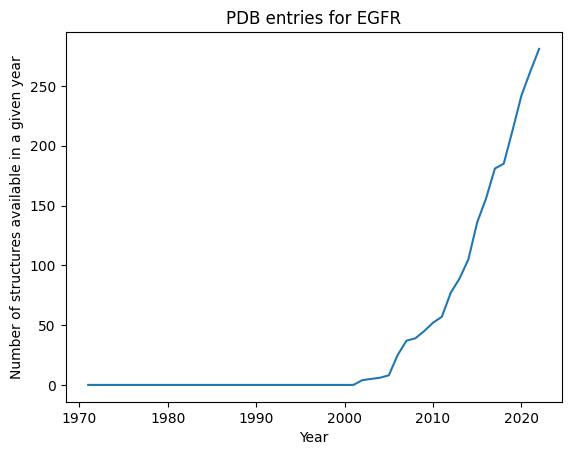

In [30]:
plt.plot(years, n_structures)
plt.title("PDB entries for EGFR")
plt.xlabel("Year")
plt.ylabel("Number of structures available in a given year");

Find PDB entries fullfilling certain conditions
We will search for PDB IDs describing structures in the PDB that fulfill the following criteria:

Structures for UniProt ID P00533: This is our target of interest, EGFR!
Structures deposited before 2020: This step is for TeachOpenCADD-internal maintanence purposes. We will only consider structures that were deposited before 2020. That way the results of this notebook will stay the same over time, allowing us to check with our continuous integration (CI) that this notebook does not go out of service.
Structure resolved by X-ray crystallography: We could include all methods but let's check out the API on how we can select experimental methods.
Structure has a resolution less than or equal to 3.0: The lower the resolution value, the higher is the quality of the structure, i.e. the certainty that the assigned 3D coordinates of the atoms are correct. Atomic orientations can be determined below 3 Å. Thus, this threshold is often used for structures relevant for structure-based drug design.
Structure has only one chain: We do this to make our lives easier lateron.
Structure has a ligand with molecular weight greater than 100.0 Da: PDB-annotated ligands can be ligands, but also solvents and ions. In order to filter only ligand-bound structures, we keep only structures with annotated ligand of a at least 100.0 Da (many solvents and ions weight less). Note: this is a simple, but not comprehensive exclusion of solvents and ions.
We make use of the biotite package again to query for PDB IDs based on the following combined queries:

In [31]:
uniprot_id = "P00533"
before_deposition_date = "2020-01-01T00:00:00Z"
experimental_method = "X-RAY DIFFRACTION"
max_resolution = 3.0
n_chains = 1
min_ligand_molecular_weight = 100.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
query_by_uniprot_id = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=uniprot_id,
)
query_by_deposition_date = rcsb.FieldQuery(
    "rcsb_accession_info.deposit_date", less=before_deposition_date
)
query_by_experimental_method = rcsb.FieldQuery("exptl.method", exact_match=experimental_method)
query_by_resolution = rcsb.FieldQuery(
    "rcsb_entry_info.resolution_combined", less_or_equal=max_resolution
)
query_by_polymer_count = rcsb.FieldQuery(
    "rcsb_entry_info.deposited_polymer_entity_instance_count", equals=n_chains
)
query_by_ligand_mw = rcsb.FieldQuery(
    "chem_comp.formula_weight", molecular_definition=True, greater=min_ligand_molecular_weight
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
print(f"Number of structures with UniProt ID {uniprot_id}: {rcsb.count(query_by_uniprot_id)}")
time.sleep(0.1)  # wait shortly to not overload the API
print(
    f"Number of structures deposited before {before_deposition_date}: {rcsb.count(query_by_deposition_date)}"
)
time.sleep(0.1)
print(
    f"Number of structures resolved by {experimental_method}: {rcsb.count(query_by_experimental_method)}"
)
time.sleep(0.1)
print(
    f"Number of structures with resolution less than or equal to {max_resolution}: {rcsb.count(query_by_resolution)}"
)
time.sleep(0.1)
print(f"Number of structures with only {n_chains} chain: {rcsb.count(query_by_polymer_count)}")
time.sleep(0.1)
print(
    f"Number of structures with ligand of more than or equal to {min_ligand_molecular_weight} Da: {rcsb.count(query_by_ligand_mw)}"
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of structures with UniProt ID P00533: 281
Number of structures deposited before 2020-01-01T00:00:00Z: 166265
Number of structures resolved by X-RAY DIFFRACTION: 176296
Number of structures with resolution less than or equal to 3.0: 168815
Number of structures with only 1 chain: 75027
Number of structures with ligand of more than or equal to 100.0 Da: 206461


In [34]:
query = rcsb.CompositeQuery(
    [
        query_by_uniprot_id,
        query_by_deposition_date,
        query_by_experimental_method,
        query_by_resolution,
        query_by_polymer_count,
        query_by_ligand_mw,
    ],
    "and",
)
pdb_ids = rcsb.search(query)
print(f"Number of matches: {len(pdb_ids)}")
print("Selected PDB IDs:")
print(*pdb_ids)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of matches: 110
Selected PDB IDs:
1M14 1M17 1XKK 2EB2 2EB3 2GS2 2ITN 2ITP 2ITQ 2ITT 2ITU 2ITV 2ITW 2ITX 2ITZ 2J5F 2RGP 3BEL 3GOP 3POZ 3UG1 3UG2 3VJN 3VJO 3W2O 3W2P 3W2Q 3W2R 3W2S 3W32 3W33 4G5J 4HJO 4I1Z 4I22 4I23 4JQ7 4JQ8 4JR3 4JRV 4LI5 4LQM 4RJ4 4RJ6 4RJ7 4RJ8 4WKQ 4WRG 4ZAU 5C8K 5C8M 5C8N 5CAL 5CAN 5CAO 5CAP 5CAQ 5CAS 5CAU 5CAV 5EDP 5EDQ 5EDR 5EM5 5EM6 5EM7 5EM8 5FED 5FEE 5GMP 5GNK 5GTZ 5HCX 5HCY 5HCZ 5HG5 5HG7 5HG8 5HG9 5HIB 5HIC 5J9Y 5J9Z 5U8L 5UG8 5UG9 5UGA 5UGB 5UGC 5X26 5X27 5X28 5XDK 5XDL 5XGM 5ZTO 5ZWJ 6D8E 6JRJ 6JRK 6JRX 6JWL 6JX0 6JX4 6JXT 6JZ0 6S89 6S8A 6S9C 6S9D


Select PDB entries with the hightest resolution
So far we have used certain search criteria to find PDB entries of interest.

At the moment, we cannot access the structures' resolution directly via biotite; with biotite we can only check if the resolution fullfils a certain condition. Instead we download the full metadata for our selected PDB IDs. To this end, we use from the pypdb package the method describe_pdb. Each structure's metadata is returned as a dictionary.

Note: we only fetch meta information on PDB structures here, we do not fetch the structures (3D coordinates), yet.

The redo.retriable line is a decorator. This wraps the function and provides extra functionality. In this case, it will retry failed queries automatically (10 times maximum).

In [35]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    """Fetch meta information from PDB."""
    described = pypdb.describe_pdb(pdb_id)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying ...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
pdbs_data = [describe_one_pdb_id(pdb_id) for pdb_id in tqdm(pdb_ids)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/110 [00:00<?, ?it/s]

In [37]:
print("\n".join(pdbs_data[0].keys()))

audit_author
cell
citation
diffrn
diffrn_detector
diffrn_radiation
diffrn_source
entry
exptl
exptl_crystal
exptl_crystal_grow
pdbx_audit_revision_details
pdbx_audit_revision_group
pdbx_audit_revision_history
pdbx_database_related
pdbx_database_status
rcsb_accession_info
rcsb_entry_container_identifiers
rcsb_entry_info
rcsb_primary_citation
refine
refine_analyze
refine_hist
refine_ls_restr
reflns
reflns_shell
software
struct
struct_keywords
symmetry
rcsb_id


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
pdbs_data[0]["entry"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'id': '1M14'}

In [39]:
pdbs_data[0]["rcsb_entry_info"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'assembly_count': 1,
 'branched_entity_count': 0,
 'cis_peptide_count': 0,
 'deposited_atom_count': 2469,
 'deposited_hydrogen_atom_count': 0,
 'deposited_model_count': 1,
 'deposited_modeled_polymer_monomer_count': 307,
 'deposited_nonpolymer_entity_instance_count': 0,
 'deposited_polymer_entity_instance_count': 1,
 'deposited_polymer_monomer_count': 333,
 'deposited_solvent_atom_count': 17,
 'deposited_unmodeled_polymer_monomer_count': 26,
 'diffrn_radiation_wavelength_maximum': 1.008,
 'diffrn_radiation_wavelength_minimum': 1.008,
 'disulfide_bond_count': 0,
 'entity_count': 2,
 'experimental_method': 'X-ray',
 'experimental_method_count': 1,
 'inter_mol_covalent_bond_count': 0,
 'inter_mol_metalic_bond_count': 0,
 'molecular_weight': 37.88,
 'na_polymer_entity_types': 'Other',
 'nonpolymer_entity_count': 0,
 'polymer_composition': 'homomeric protein',
 'polymer_entity_count': 1,
 'polymer_entity_count_dna': 0,
 'polymer_entity_count_rna': 0,
 'polymer_entity_count_nucleic_acid': 0

In [40]:
resolution = pd.DataFrame(
    [
        [pdb_data["entry"]["id"], pdb_data["rcsb_entry_info"]["resolution_combined"][0]]
        for pdb_data in pdbs_data
    ],
    columns=["pdb_id", "resolution"],
).sort_values(by="resolution", ignore_index=True)
resolution

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,pdb_id,resolution
0,5UG9,1.330
1,5HG8,1.420
2,5UG8,1.460
3,3POZ,1.500
4,5HG5,1.520
...,...,...
105,2ITX,2.980
106,5GTZ,2.999
107,2J5F,3.000
108,4I1Z,3.000


In [41]:
top_num = 6  # Number of top structures

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
selected_pdb_ids = resolution[:top_num]["pdb_id"].to_list()
print(f"Selected PDB IDs: {selected_pdb_ids}")

Selected PDB IDs: ['5UG9', '5HG8', '5UG8', '3POZ', '5HG5', '5UGC']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
selected_pdb_ids = ["5UG9", "5HG8", "5UG8", "5UGC"]
print(f"Selected PDB IDs (frozen set): {selected_pdb_ids}")

Selected PDB IDs (frozen set): ['5UG9', '5HG8', '5UG8', '5UGC']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
def get_ligands(pdb_id):
    """
    RCSB has not provided a new endpoint for ligand information yet. As a
    workaround we are obtaining extra information from ligand-expo.rcsb.org,
    using HTML parsing. Check Talktorial T011 for more info on this technique!
    """
    pdb_info = _fetch_pdb_nonpolymer_info(pdb_id)
    ligand_expo_ids = [
        nonpolymer_entities["pdbx_entity_nonpoly"]["comp_id"]
        for nonpolymer_entities in pdb_info["data"]["entry"]["nonpolymer_entities"]
    ]

    ligands = {}
    for ligand_expo_id in ligand_expo_ids:
        ligand_expo_info = _fetch_ligand_expo_info(ligand_expo_id)
        ligands[ligand_expo_id] = ligand_expo_info

    return ligands


def _fetch_pdb_nonpolymer_info(pdb_id):
    """
    Fetch nonpolymer data from rcsb.org.
    Thanks @BJWiley233 and Rachel Green for this GraphQL solution.
    """
    query = (
        """{
          entry(entry_id: "%s") {
            nonpolymer_entities {
              pdbx_entity_nonpoly {
                comp_id
                name
                rcsb_prd_id
              }
            }
          }
        }"""
        % pdb_id
    )

    query_url = f"https://data.rcsb.org/graphql?query={query}"
    response = requests.get(query_url)
    response.raise_for_status()
    info = response.json()
    return info


def _fetch_ligand_expo_info(ligand_expo_id):
    """
    Fetch ligand data from ligand-expo.rcsb.org.
    """
    r = requests.get(f"http://ligand-expo.rcsb.org/reports/{ligand_expo_id[0]}/{ligand_expo_id}/")
    r.raise_for_status()
    html = BeautifulSoup(r.text)
    info = {}
    for table in html.find_all("table"):
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) != 2:
                continue
            key, value = cells
            if key.string and key.string.strip():
                info[key.string.strip()] = "".join(value.find_all(string=True))

    # Postprocess some known values
    info["Molecular weight"] = float(info["Molecular weight"].split()[0])
    info["Formal charge"] = int(info["Formal charge"])
    info["Atom count"] = int(info["Atom count"])
    info["Chiral atom count"] = int(info["Chiral atom count"])
    info["Bond count"] = int(info["Bond count"])
    info["Aromatic bond count"] = int(info["Aromatic bond count"])
    return info

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
columns = [
    "@structureId",
    "@chemicalID",
    "@type",
    "@molecularWeight",
    "chemicalName",
    "formula",
    "InChI",
    "InChIKey",
    "smiles",
]
rows = []
for pdb_id in selected_pdb_ids:
    ligands = get_ligands(pdb_id)
    # If several ligands contained, take largest (first in results)
    ligand_id, properties = max(ligands.items(), key=lambda kv: kv[1]["Molecular weight"])
    rows.append(
        [
            pdb_id,
            ligand_id,
            properties["Component type"],
            properties["Molecular weight"],
            properties["Name"],
            properties["Formula"],
            properties["InChI descriptor"],
            properties["InChIKey descriptor"],
            properties["Stereo SMILES (OpenEye)"],
        ]
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# NBVAL_CHECK_OUTPUT
# Change the format to DataFrame
ligands = pd.DataFrame(rows, columns=columns)
ligands

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,NON-POLYMER,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,NON-POLYMER,377.400,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,NON-POLYMER,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,5UGC,8BS,NON-POLYMER,417.441,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C18 H24 F N9 O2,InChI=1S/C18H24FN9O2/c1-5-13(29)21-11-8-28(6-1...,XWNKXCUQRQRAFF-GHMZBOCLSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...


In [48]:
ligands.to_csv(DATA / "/content/teachopencadd/teachopencadd/talktorials/T008_query_pdb/data/PDB_top_ligands.csv", header=True, index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


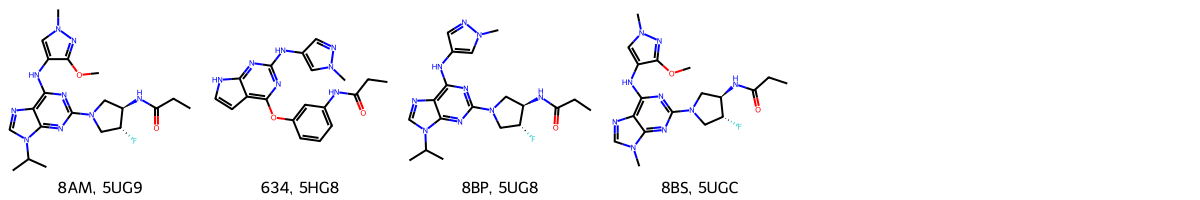

In [49]:
PandasTools.AddMoleculeColumnToFrame(ligands, "smiles")
Draw.MolsToGridImage(
    mols=list(ligands.ROMol),
    legends=list(ligands["@chemicalID"] + ", " + ligands["@structureId"]),
    molsPerRow=top_num,
)

In [50]:
# NBVAL_CHECK_OUTPUT
pairs = collections.OrderedDict(zip(ligands["@structureId"], ligands["@chemicalID"]))
pairs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


OrderedDict([('5UG9', '8AM'),
             ('5HG8', '634'),
             ('5UG8', '8BP'),
             ('5UGC', '8BS')])

Align PDB structures and extract ligands
Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D.

We will use the Python package opencadd (repository), which includes a 3D superposition subpackage to guide the structural alignment of the proteins. The approach is based on superposition guided by sequence alignment of provided matched residues. There are other methods in the package, but this simple one will be enough for the task at hand.

Get the PDB structure files
We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using opencadd.structure.superposition.

Available file formats are pdb and cif, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with pdb files.

In [51]:
# # Download PDB structures
# structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
# structures

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: ignored